# DepthAI Tutorial: Training a Tiny YOLOv3 Object Detector with Your Own Data

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

**<font color="red">Warning! This tutorial is now deprecated. Please refer to [this tutorial](https://colab.research.google.com/github/luxonis/depthai-ml-training/blob/master/colab-notebooks/YoloV3_V4_tiny_training.ipynb) for YoloV3-tiny and YoloV4-tiny tutorial.</font>**

Welcome to DepthAI!

In this tutorial we will train an object detector using the Tiny YOLOv3 model. This model will run on our DepthAI Myriad X modules.

The model is pretrained on the COCO dataset. The framework used for training is Darknet.
Will run through the following steps:


*   Install the libraries (Darknet , etc.)
*   Clone the github repo and replace the repo training data with your data (from google drive or from own repo - which is faster)
*   Train the model on the new images
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: the model training can be run with the repo images of medical masks if you choose to skip the customization part for your own images just to see how the training and the rest of the steps work

## STEP 1 Install Darknet


In [17]:
%cd /content
!rm -r darknet/
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet


/content
Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.39 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (10666/10666), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunu

In [2]:
%tensorflow_version 1.x

ValueError: Tensorflow 1 is unsupported in Colab.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

In [19]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [20]:
#utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()




## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint.
Changes to some files need to be made according to own data, but it is nothing complicated.

In [21]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
%rm -r {repo_dir_path}
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Counting objects: 100% (1732/1732), done.
remote: Compressing objects: 100% (1494/1494), done.
remote: Total 1733 (delta 119), reused 1732 (delta 119), pack-reused 1
Receiving objects: 100% (1733/1733), 208.88 MiB | 33.15 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Updating files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


### Now go to the file explorer on the left of the colab notebook and click on content then on the yolotinyv3_medmask_demo folder.
Here you will see a folder and a few files.
The `obj` folder contains both images AND the associated annotations in yolo format.

(to annotate own images use https://github.com/tzutalin/labelImg and save annotations in yolo format)

* the 'obj.data' file contains paths for files used by Darknet and the number of classes to train the yolo model.

* the 'obj.names' file has the labels of the objects to be detected. the number of objects gives the number of classes in the 'obj.data' file.

* the train.txt contains the path to each image to be used in training. similarly, valid.txt and test.txt contain the path to each image for validation and testing. when not many images are available for training (a few hundred), use all images for training for better model performance.

* the yolov4-tiny.conv.29 are the COCO pretrained weights

* the yolov4-tiny_obj.cfg are is the tiny yolov4 configuration file that tells Darknet the model parameters and structure

So we can see that all these files need to be changed according to own data.


# How to use your own images
In order to use your own annotated images, follow the steps below. If you want to train on the images already in the repo, skip this section and jump to the Train model section.

## Let's start with the images and annotations
We copy the images on our google drive in a folder. My gdrive folder is named medmask_yolo. Then we mount the gdrive in colab and copy the images and annotations in the obj folder. Change the **`if (False):`** to **`if (True):`** to use your own images from gdrive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## REMOVE THIS TO USE YOUR OWN IMAGES
if (False):
  #remove the obj folder
  !rm -rf /content/yolotinyv3_medmask_demo/obj
  #copy images to obj folder
  #this can take a few minutes depending on dataset size.
  !cp -rf '/content/drive/My Drive/datasets/medmask_yolo/obj' '/content/yolotinyv3_medmask_demo/obj'

### The copy operation from gdrive to colab may take a while
The fastest way to add data to colab is to create a github repo with your images and annotations and clone that repo here. Then copy the files from your cloned repo to the obj folder.
First delete the obj folder using

In [ ]:
# !rm -rf /content/yolotinyv3_medmask_demo/obj

Then copy from your cloned repo folder with images and annotations to the `obj` folder

In [ ]:
# assuming your cloned image/annotation folder is named MyImages and it is under /content,
# the copy would be:
# !cp -rf '/content/MyImages' '/content/yolotinyv3_medmask_demo/obj'

## Change the labels in obj.names to our current labels

In [ ]:
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['mask','no mask']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

mask
no mask

## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [ ]:
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes= 2
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/valid.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

## Now we need to create a train.txt, valid.txt and test.txt file for our images from `obj` folder.
We will use a script that splits the images based on a specified percentage
and writes them in train.txt, valid.txt and test.txt files.

In [ ]:
%cd ../yolotinyv3_medmask_demo/

/content/yolotinyv3_medmask_demo


In [ ]:
#in this case we use 85 percent of the images for training
#10 percent for validation, 5 for testing.
#as the dataset is small, one can use 90 percent for training and split the rest
#for validation/testing as desired.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
!python3 folder2textYolo.py 85 10 /content/yolotinyv3_medmask_demo/obj

Your image file extension is: .jpg
Number of images: 762
Number of images used for training 648
Number of images used for validation 76
Number of images used for testing 38


## Last thing we need to change is the yolov3-tiny_obj.cfg file.
There are several parameters of importance here. They control various aspects of the training process. Let's print the first few lines and have a look


In [ ]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



### Let's go over the parameters above:
* The batch parameter dictates the batch size. That one generally remains at 64.
* The subdivisions dictates how many images are loaded into memory. A smaller number translates to faster training. We will use 12. If a CUDA out of memory error is triggered, the subdivisions should be increased to i.e. 16,24,32 or some other number. (64 is max) Unless training with a resolution higher than 416, there should be no problem with 12.
* The width and height are by default at 416. Another resolution one can try is 320, or 608.
* The next parameter we care about is max_batches. This determines how long the training process is. Its value should be at least around 2000 for every class used. So for 3 classes, at least 6000.
* The steps are calculated as a function of max_batches. The first value is 0.8 * max_batches and the second value 0.9 * max_batches. In this case it is 8000 * 0.8 and 8000 * 0.9.

For more details about Yolo parameters have a look here:
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects
There is a lot of material here, so make sure you scroll through if you have questions. Pretty much everything is well explained.




### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3


cfg_file = '/content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg'
# cfg_file = '/content/yolotinyv3_medmask_demo/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



Let's look again at the configuration

In [ ]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 40
policy=steps
steps=32,36
scales=.1,.1



We also check if the number of classes and filters updated correctly

In [ ]:
!tail -n 64 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg


stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


# Train the model

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

In the `content/darknet/backup/` folder Darknet saves a few weights files:
* files that end in 1000,2000 etc are weights saved every 1000 batches
* best weights file are the weights that gave best results during training
* final weights file contains the final weights at the end of the training





## Start the model training
For training details check here:

https://github.com/AlexeyAB/darknet#how-to-train-tiny-yolo-to-detect-your-custom-objects

In [22]:
%cd /content/darknet/

/content/darknet


In [23]:
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg /content/yolotinyv3_medmask_demo/yolov3-tiny.conv.15 -dont_show -ext_output -map

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 total_bbox = 240724, rewritten_bbox = 0.040295 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.743456), count: 2, class_loss = 0.115605, iou_loss = 0.119789, total_loss = 0.235395 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.709857), count: 18, class_loss = 2.625571, iou_loss = 1.014336, total_loss = 3.639906 
 total_bbox = 240744, rewritten_bbox = 0.040292 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.662176), count: 8, class_loss = 1.287994, iou_loss = 0.804541, total_loss = 2.092535 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.664306), count: 17, class_loss = 2.640526, iou_loss = 1.785719, total_loss = 4.426246 
 total_bbox = 240769, rewritten_bbox = 0.040288 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.759930), count: 2, class_loss = 0.821687, iou_loss = 0.

## Check the model performance
The metrics run on the validation images so they may not be fully representative, only indicative

In [24]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg "/content/darknet/backup/yolov3-tiny_obj_best.weights" -points 0

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

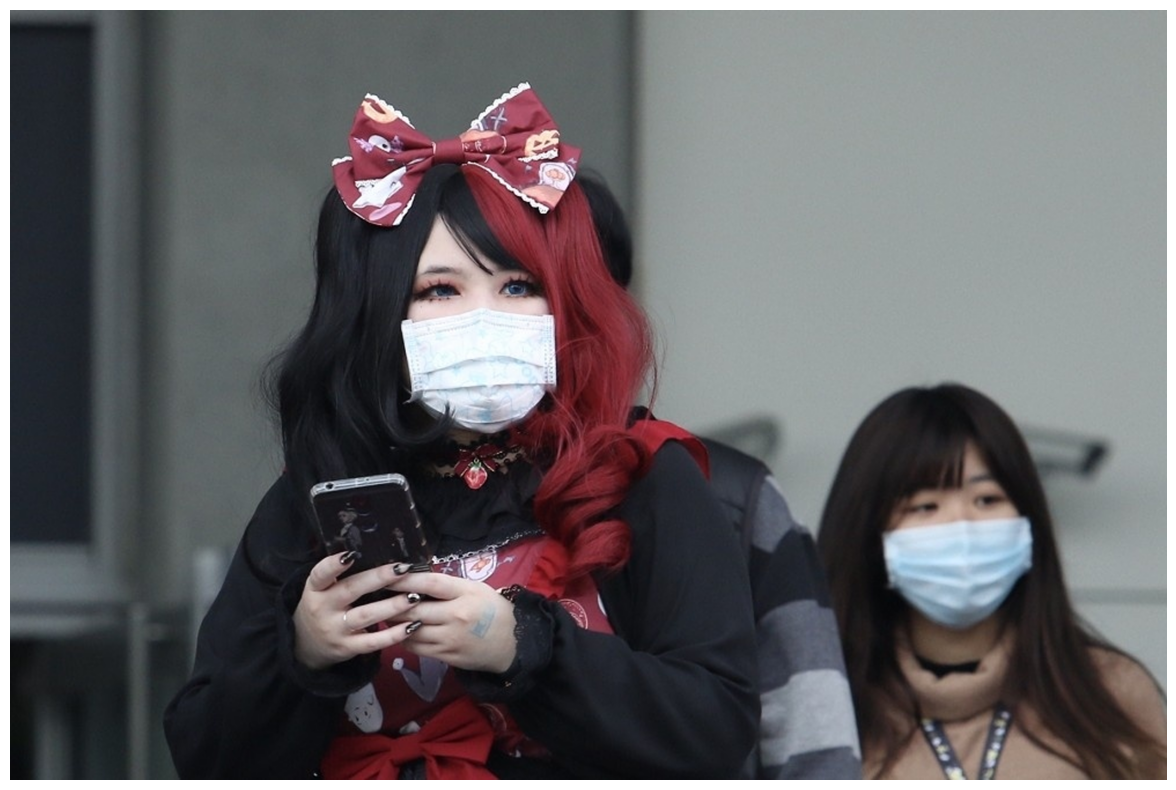

In [18]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_last.weights" /content/yolotinyv3_medmask_demo/obj/0633.jpg -ext_output
imShow('/content/yolotinyv3_medmask_demo/obj/0175.jpg')

## Copy best weights to google drive


In [11]:
!cp /content/darknet/backup/yolov3-tiny_obj_best.weights  '/content/drive/My Drive/'

cp: cannot stat '/content/darknet/backup/yolov3-tiny_obj_best.weights': No such file or directory


# Convert model so it can be used on DepthAI
This requires three steps:
1. Convert model to Tensorflow frozen model
2. Convert Tf model to OpenVINO IR files .xml and .bin
3. Compile a blob from the IR files. The blob can be used for inference on DepthAI modules.

### Convert YOLO model to Tensorflow frozen model


In [12]:
%cd /content
#clone a repo that helps with the conversion
!git clone https://github.com/mystic123/tensorflow-yolo-v3.git
%cd tensorflow-yolo-v3/
!git checkout ed60b90

/content
Cloning into 'tensorflow-yolo-v3'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 232 (delta 4), reused 1 (delta 0), pack-reused 222
Receiving objects: 100% (232/232), 64.25 KiB | 557.00 KiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/tensorflow-yolo-v3
Note: switching to 'ed60b90'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ed60b90 Merge pull request #53 from alexzhangxx/small_cha

Convert the best yolo weights to Tensorflow frozen model.
The name and location of the frozen model is


 `/content/tensorflow-yolo-v3/frozen_darknet_yolov3_model.pb`

In [13]:
!python3 convert_weights_pb.py --class_names /content/yolotinyv3_medmask_demo/obj.names --data_format NHWC --weights_file /content/darknet/backup/yolov3-tiny_obj_best.weights --tiny


2024-04-29 05:41:49.602861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 05:41:49.602914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 05:41:49.604218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 05:41:50.646988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/tensorflow-yolo-v3/convert_weights_pb.py", line 5, in <module>
    import yolo_v3
  File "/content/tensorflow-yolo-v3/yolo_v3.py", line 6, in <module>
    slim = tf.contrib.slim
AttributeEr

###Install OpenVINO 21.03

In [14]:
%cd /content

/content


In [15]:
import os
from urllib.parse import urlparse

## install tools. Open Vino takes some time to download - it's ~400MB
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove

## downnload installation files
url = "https://registrationcenter-download.intel.com/akdlm/irc_nas/17662/l_openvino_toolkit_p_2021.3.394.tgz"
!wget {url}

## Get the name of the tgz
parsed = urlparse(url)
openvino_tgz = os.path.basename(parsed.path)
openvino_folder = os.path.splitext(openvino_tgz)[0]

## Extract & install openvino
!tar xf {openvino_tgz}
%cd {openvino_folder}
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids
Suggested packages:
  libarchive1
The following NEW packages will be installed:
  cpio libpci3 pci.ids pciutils
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 426 kB of archives.
After this operation, 1,913 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 cpio amd64 2.13+dfsg-7 [83.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 426 kB in 1s (576 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/shar

###Convert frozen TF model to openvino 20.01 IRv10
--input model is the path to the frozen model from above

--output_dir is where we want to save the converted IR files: .xml .bin and .mapping. we save it in TinyIR in the /content/yolotinyv3_medmask_demo directory

In [ ]:
%cd ..

/content


In [ ]:
tiny_yolo_json = '/content/yolotinyv3_medmask_demo/yolo_v3_tiny.json'

with open(tiny_yolo_json) as f:
    s = f.read()
s = re.sub('"classes": \d*','"classes": ' + str(len(labels)),s)
with open(tiny_yolo_json, 'w') as f:
  f.write(s)
#Check that the number of classes is correct (same as the number of your training labels)|
!cat /content/yolotinyv3_medmask_demo/yolo_v3_tiny.json

[
  {
    "id": "TFYOLOV3",
    "match_kind": "general",
    "custom_attributes": {
      "classes": 2,
      "anchors": [10, 14, 23, 27, 37, 58, 81, 82, 135, 169, 344, 319],
      "coords": 4,
      "num": 6,
      "masks": [[3, 4, 5], [1, 2, 3]],
      "entry_points": ["detector/yolo-v3-tiny/Reshape", "detector/yolo-v3-tiny/Reshape_4"]
    }
  }
]

In [ ]:

# Get openvino installation path
openvino = !find /opt/intel -type d -name openvino*

!python -mpip install -r {openvino[0]}/deployment_tools/model_optimizer/requirements.txt

!source {openvino[0]}/bin/setupvars.sh && \
    python {openvino[0]}/deployment_tools/model_optimizer/mo.py \
--input_model /content/tensorflow-yolo-v3/frozen_darknet_yolov3_model.pb \
--tensorflow_use_custom_operations_config /content/yolotinyv3_medmask_demo/yolo_v3_tiny.json \
--batch 1 \
--data_type FP16 \
--reverse_input_channel \
--output_dir /content/yolotinyv3_medmask_demo/TinyIR

Ignoring tensorflow: markers 'python_version >= "3.8"' don't match your environment
     |████████████████████████████████| 68.7MB 45kB/s 
     |████████████████████████████████| 20.1MB 77.8MB/s 
     |████████████████████████████████| 12.2MB 217kB/s 
     |████████████████████████████████| 143kB 57.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=2a4c5a5871547151ce98eb453cda5778e5da0dbe6d6219add120f9e54f6fa716
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: lucid 0.3.10 requires umap-learn, which is not installed.
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatib

## Now we compile the IR model to a .blob for use on DepthAI modules/platform

### We save the blob in the IR directory from above, corresponding to --output_dir parameter above.
The blob filename and location will be

 `/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.blob`

In [ ]:
blob_dir = "/content/yolotinyv3_medmask_demo/TinyIR/"
binfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.bin"
xmlfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.xml"

!python -m pip install blobconverter

import blobconverter
blob_path = blobconverter.from_openvino(
    xml=xmlfile,
    bin=binfile,
    data_type="FP16",
    shaves=5,
)
from google.colab import files
files.download(blob_path)

     |████████████████████████████████| 133kB 7.5MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 7.6MB 10.9MB/s 
     |████████████████████████████████| 133kB 48.8MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.5
    Uninstalling urllib3-1.26.5:
      Successfully uninstalled urllib3-1.26.5
[==================================================]
Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Run the blob on DepthAI

To use this blob with DepthAI:

- Clone depthai demo script

    ```
    $ git clone https://github.com/luxonis/depthai.git
    ```
- Install requirements

    ```
    $ python3 install_requirements.py
    ```
- Create a new model directory and insert the blob

    ```
    $ mkdir resources/nn/custom_tinyyolo
    $ mv <downloaded_blob> resources/nn/custom_tinyyolo/
    ```

- Copy config file from yolo model

    ```
    $ cp resources/nn/tiny-yolo-v3/tiny-yolo-v3.json resources/nn/custom_tinyyolo/custom_tinyyolo.json
    ```

- Run the demo script

    ```
    $ python3 depthai_demo.py -cnn custom_tinyyolo
    ```

You can read more details on deployment [here](https://docs.luxonis.com/en/latest/pages/tutorials/first_steps/#using-custom-models)

In [ ]:
#Compress the folder with the Tensorflow model and OpenVINO IR_V10 folder and download it locally.
#These are in content/models/research/fine_tuned_model, so we compress the fine_tuned_model folder.
!tar czvf fine_tuned_model.tar.gz {blob_dir}

tar: Removing leading `/' from member names
/content/yolotinyv3_medmask_demo/TinyIR/
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.mapping
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.xml
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.bin


In [ ]:
#download the compressed IRv10 folder locally
#or can use file navigator on the left to move it to your gdrive
from google.colab import files
files.download("fine_tuned_model.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>